In [1]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer, defecitRestoration, lowResDefecitRestoration, probalisticDeficitRestoration, noisyDefecitRestoration, utopianRestoration, flowRestoration, lowResFlowRestoration, greedyFlowRestoration, bfsFlowRestoration, lowResFlowRestoration
from ecoscape_connectivity_local import repopulation, util
import matplotlib.pyplot as plt
import ecoscape_connectivity
from scgt import GeoTiff, Tile
import numpy as np
import torch
import rasterio

In [6]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
locations = ['smol'] # 'smol2', 'california']
birds_params = {'acowoo': (2,40), 'oaktit': (1, 20)}
approaches = ['flow_approach', 'bfs_flow_approach', 'greedy_flow_approach', 'low_res_flow_approach', 'death_approach', 'utopian_approach']

# INPUTS
HABITAT_PATH = os.path.join(DATA_PATH, "{}/{}/habitat.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "{}/terrain.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "transmission_refined_1.csv")

# OUTPUTS
CONNECTIVITY_PATH = os.path.join(DATA_PATH, "{}/{}/{}/repop.tif")
FLOW_PATH = os.path.join(DATA_PATH, "{}/{}/{}/grad.tif")
DEATH_PATH = os.path.join(DATA_PATH, "{}/{}/{}/death.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "{}/{}/{}/restored_terrain.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "{}/{}/{}/repop_after_restoration.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "{}/{}/{}/grad_after_restoration.tif")
SCALED_FLOW_PATH = os.path.join(DATA_PATH, "{}/{}/{}/scaled_flow.tif")
UTOPIAN_CONN_PATH = os.path.join(DATA_PATH, "{}/{}/{}/utopian_repop.tif")
UTOPIAN_FLOW_PATH = os.path.join(DATA_PATH, "{}/{}/{}/utopian_grad.tif")

# ANALYSIS
TERRAIN_CHANGED_PATH = os.path.join(DATA_PATH, "{}/{}/{}/changed_terrain_{}_{}.tif")
CONNECTIVITY_DIFF_PATH = os.path.join(DATA_PATH, "{}/{}/{}/connectivity_diff_{}_{}.tif")

unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,1402]

---------flow_approach, acowoo, smol---------


<Figure size 500x500 with 0 Axes>

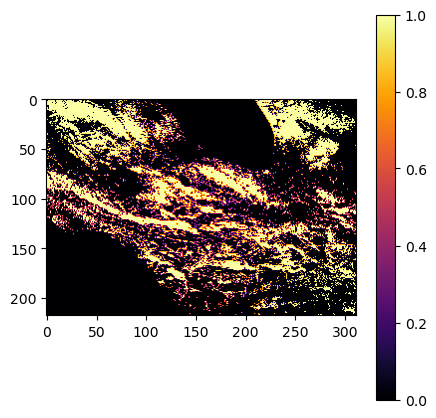

<Figure size 500x500 with 0 Axes>

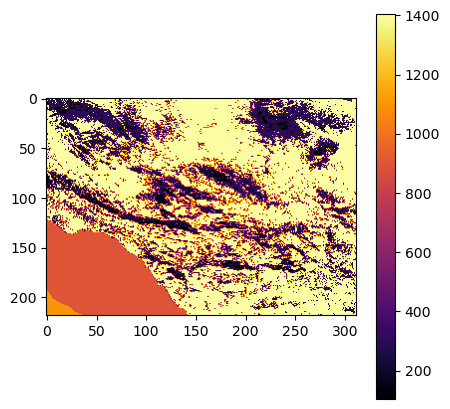

gap_crossing: 2, num_gaps: 40


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<Figure size 500x500 with 0 Axes>

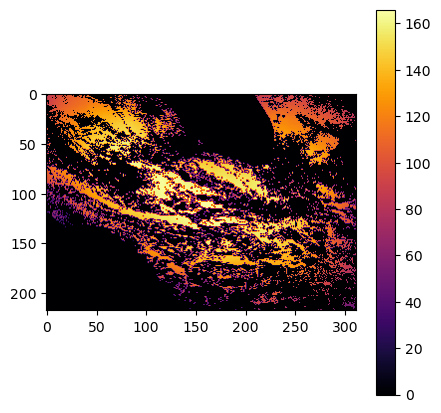

<Figure size 500x500 with 0 Axes>

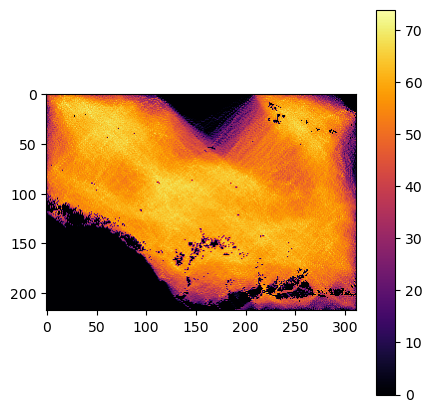

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [9]:
conn_perm_results = {}
conn_px_results = {}

for location in locations:
    for bird, params in birds_params.items():
        for approach in approaches:
            print(f'---------{approach}, {bird}, {location}---------')
            # INPUTS
            hab_path = HABITAT_PATH.replace('{}', location, 1).replace('{}', bird, 1)
            terr_path = TERRAIN_PATH.replace('{}', location, 1)
            permeability_path = PERMEABILITY_PATH

            # OUTPUTS
            conn_path = CONNECTIVITY_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
            flow_path = FLOW_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
            death_path = DEATH_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
            restored_terr_path = RESTORED_TERRAIN_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
            restored_conn_path = RESTORED_CONNECTIVITY_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
            restored_flow_path = RESTORED_FLOW_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
            
            # ANALYSIS
            terrain_changed_path = TERRAIN_CHANGED_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1).replace('{}', bird, 1).replace('{}', approach, 1)
            conn_diff_path = CONNECTIVITY_DIFF_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1).replace('{}', bird, 1).replace('{}', approach, 1)

            with GeoTiff.from_file(hab_path) as hab:
                hab_mat = hab.get_all_as_tile().m.squeeze(0)
                hab.draw_geotiff()
            with GeoTiff.from_file(terr_path) as terr:
                terr.draw_geotiff()

            if approach == 'flow_approach':
                optimizer = flowRestoration(hab_path, terr_path, restored_terr_path, conn_path, flow_path, restored_conn_path, restored_flow_path, death_path, permeability_path, 50, hab_mat, unrestorable)
            elif approach == 'bfs_flow_approach':
                optimizer = bfsFlowRestoration(hab_path, terr_path, restored_terr_path, conn_path, flow_path, restored_conn_path, restored_flow_path, death_path, permeability_path, 50, hab_mat, unrestorable, num_corridors=10)
            elif approach == 'greedy_flow_approach':
                optimizer = greedyFlowRestoration(hab_path, terr_path, restored_terr_path, conn_path, flow_path, restored_conn_path, restored_flow_path, death_path, permeability_path, 50, hab_mat, unrestorable)
            elif approach == 'low_res_flow_approach':
                scaled_flow_path = SCALED_FLOW_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
                optimizer = lowResFlowRestoration(hab_path, terr_path, restored_terr_path, conn_path, flow_path, restored_conn_path, restored_flow_path, death_path, scaled_flow_path, permeability_path, 2, 2, 50, hab_mat, unrestorable, 0.75)
            elif approach == 'death_approach':
                optimizer = defecitRestoration(hab_path, terr_path, restored_terr_path, conn_path, flow_path, restored_conn_path, restored_flow_path, death_path, permeability_path, 50, hab_mat, unrestorable)
            elif approach == 'utopian_approach':
                utopian_conn_path = UTOPIAN_CONN_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
                utopian_flow_path = UTOPIAN_FLOW_PATH.replace('{}', location, 1).replace('{}', bird, 1).replace('{}', approach, 1)
                optimizer = utopianRestoration(hab_path, terr_path, restored_terr_path, conn_path, flow_path, restored_conn_path, restored_flow_path, death_path, permeability_path, 50, utopian_conn_path, utopian_flow_path, hab_mat, unrestorable)

            # PERFORM RESTORATION
            gap_crossing, num_gaps = params
            print(f'gap_crossing: {gap_crossing}, num_gaps: {num_gaps}')
            optimizer.run_connectivity(gap_crossing=gap_crossing, num_gaps=num_gaps)
            with GeoTiff.from_file(optimizer.connectivity_fn) as conn:
                conn.draw_geotiff()
            with GeoTiff.from_file(optimizer.flow_fn) as flow:
                flow.draw_geotiff()

            permiability_restored = optimizer.restore()
            optimizer.run_connectivity(gap_crossing=gap_crossing, num_gaps=num_gaps, restored=True)

            # RESULTS
            print(f"Delta connectivity: {optimizer.get_delta_connectivity()}")
            print(f"Permiability Restored: {round(permiability_restored, 3)}")
            print(f"Connectivity/permiability restored: {round(optimizer.get_delta_connectivity()/permiability_restored, 2)}")
            print(f"Connectivity/pixels restored: {round(optimizer.get_delta_connectivity()/optimizer.pixels, 2)}")
            conn_perm_results[f'{approach}_{bird}_{location}'] = round(optimizer.get_delta_connectivity()/permiability_restored, 2)
            conn_px_results[f'{approach}_{bird}_{location}'] = round(optimizer.get_delta_connectivity()/optimizer.pixels, 2)

            optimizer.paint_changed_terrain_geotiff(terrain_changed_path, value=1)
            optimizer.get_connectivity_difference_tif(conn_diff_path)

print(conn_perm_results)
print(conn_px_results)

In [5]:
print(optimizer.unrestorable_terrain)

None


OAKTIT

In [2]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/oaktit/habitat.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/oaktit/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/oaktit/restored_terrain.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "smol/oaktit/transmission_refined_1.csv")

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/oaktit/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/oaktit/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/oaktit/grad.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/oaktit/death.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/oaktit/grad_after_restoration.tif")
LOW_RES_FLOW_PATH = os.path.join(DATA_PATH, "smol/oaktit/flow_low_res.tif")

permiability_dict = ecoscape_connectivity.util.read_transmission_csv(PERMEABILITY_PATH)
unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,    1402]

with GeoTiff.from_file(HABITAT_PATH) as hab:
    hab_mat = hab.get_all_as_tile().m.squeeze(0)

flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50, hab_mat, unrestorable)
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, RESTORED_CONNECTIVITY_PATH, FLOW_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50)

In [26]:
perm2 = ecoscape_connectivity.util.read_transmission_csv(PERMEABILITY_PATH)
print(perm1)
print(perm2)
print(perm1 == perm2)

{0: 0.0, 100: 0.0, 104: 1.0, 105: 1.0, 107: 0.0, 108: 0.009635036, 201: 0.033518248, 300: 0.0, 303: 0.0, 304: 0.3585985401459854, 305: 0.098744526, 308: 1.0, 400: 0.0, 401: 0.001868613, 404: 0.9, 405: 0.9, 500: 0.031532846715328466, 501: 0.001693431, 502: 0.000175182, 505: 0.045255474, 506: 0.001284672, 507: 0.0, 510: 0.0, 511: 0.001226277, 513: 0.000817518, 514: 0.0, 515: 0.0, 600: 0.00070073, 801: 0.000817518, 802: 0.000350365, 803: 0.000583942, 900: 0.014540146, 909: 0.006014599, 1101: 0.0, 1102: 0.0, 1103: 0.0, 1105: 0.0, 1106: 0.0, 1200: 0.000934307, 1206: 0.0, 1401: 0.2715912408759124, 1402: 0.9, 1403: 0.9091386861313868, 1405: 0.0}
{0: 0.0, 100: 0.0, 104: 1.0, 105: 0.9, 107: 0.0, 108: 0.007304514429409652, 201: 0.0004310860974733565, 300: 0.0, 303: 0.001029816788408574, 304: 0.3239612022512274, 305: 0.052496706981199855, 308: 0.2124056999161777, 400: 0.0, 401: 0.015351454915578973, 404: 0.040210753203209194, 405: 0.000862172194946713, 500: 0.016644713207999044, 501: 0.0006945276

# Flow based restoration

In [16]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

flowOptimizer.run_connectivity(gap_crossing=1, num_gaps=10)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=1, num_gaps=10, restored=True)

print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 95236
Permiability Restored: 38.92954137229072
Percent connectivity changed: 0.0440790067458894%
Connectivity/permiability_restored: 2446.37
Connectivity/permiability_restored: 1904.72


In [11]:
print(f"Connectivity/pixels restored: {round(flowOptimizer.get_delta_connectivity()/flowOptimizer.pixels, 2)}")

Connectivity/permiability_restored: 1904.72


In [12]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50)

flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 22113
Permiability Restored: 4.981722627737225
Percent connectivity changed: 0.008361933745864978%
Connectivity/permiability_restored: 4438.83


In [6]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

# flowOptimizer.run_connectivity()
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {flowOptimizer.get_delta_connectivity()/permiability_restored}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 15522
Permiability Restored: 4.999999999999998
Percent connectivity changed: 0.005763508990026924%
Connectivity/permiability_restored: 3104.400000000001


In [7]:
print(flowOptimizer.changed_pixels)

{(277, 36): 79, (278, 36): 71, (103, 117): 69, (188, 108): 67, (89, 132): 66, (11, 115): 66, (176, 109): 65, (155, 139): 64, (248, 143): 63, (15, 115): 63, (250, 141): 63, (15, 113): 63, (143, 87): 63, (118, 145): 63, (109, 142): 63, (220, 198): 63, (183, 173): 62, (176, 174): 62, (277, 118): 62, (104, 66): 62, (270, 33): 62, (199, 159): 62, (21, 102): 62, (163, 105): 62, (216, 114): 62, (45, 25): 61, (41, 85): 61, (190, 175): 61, (204, 109): 61, (23, 102): 61, (270, 32): 60, (267, 188): 60, (283, 38): 60, (271, 40): 60, (289, 131): 60, (186, 114): 60, (236, 197): 60, (177, 174): 60, (95, 103): 60, (41, 74): 59, (43, 72): 59, (163, 89): 59, (109, 141): 59, (276, 146): 59, (245, 102): 59, (22, 102): 59, (226, 162): 59, (119, 145): 59, (198, 160): 59, (205, 205): 59}


In [12]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_low_flow.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_low_flow.tif")

def get_connectivity_difference_tif(flowOptimizer, connectivity_diff_fn):
    # get origional connectivity
    with GeoTiff.from_file(flowOptimizer.connectivity_fn) as connectivity_tif:
        connectivity_tile = connectivity_tif.get_all_as_tile()
        # create connectivity diff tif from clone of connectivity_tif
        connectivity_tif.clone_shape(connectivity_diff_fn, dtype='int16')

    # get restored connectivity
    with GeoTiff.from_file(flowOptimizer.restored_connectivity_fn) as restored_connectivity_tif:
        restored_connectivity_tile = restored_connectivity_tif.get_all_as_tile()

    # get the difference of the two in a tile
    diff = Tile(connectivity_tile.w, connectivity_tile.h, connectivity_tile.b, connectivity_tile.c, connectivity_tile.x, connectivity_tile.y, (restored_connectivity_tile.m.astype('int16') - connectivity_tile.m.astype('int16')))
    # write the tile to connectivity diff tif
    with GeoTiff.from_file(connectivity_diff_fn) as connectivity_diff:
        connectivity_diff.set_tile(diff)


# paint changed terrain pixels
flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, flowOptimizer.changed_pixels, value=1)
# view diff of before and after
get_connectivity_difference_tif(flowOptimizer, CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


# Low Res Flow

In [14]:
# Flow restoration
lowResFlowOptimizer = lowResFlowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, LOW_RES_FLOW_PATH, PERMEABILITY_PATH, 2, 2, 50, percent_impermiable=0.25) #hab_mat, unrestorable)

lowResFlowOptimizer.run_connectivity(gap_crossing=1, num_gaps=10)
permiability_restored = lowResFlowOptimizer.restore()
lowResFlowOptimizer.run_connectivity(gap_crossing=1, num_gaps=10, restored=True)

print(f"Delta connectivity: {lowResFlowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {lowResFlowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(lowResFlowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/pixels restored: {round(lowResFlowOptimizer.get_delta_connectivity()/lowResFlowOptimizer.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


[(234, 21), (49, 107), (21, 21), (34, 42), (166, 160), (188, 160), (152, 164), (220, 105), (125, 89), (234, 30), (190, 159), (128, 90), (13, 17), (130, 101), (269, 58), (269, 20), (122, 122), (163, 164), (242, 8), (30, 97), (278, 57), (65, 52), (285, 103), (7, 83), (272, 48), (119, 100), (243, 7), (222, 141), (85, 49), (108, 94), (32, 37), (120, 96), (281, 27), (61, 48), (158, 161), (272, 63), (236, 163), (240, 11), (294, 117), (295, 117), (198, 92), (108, 91), (72, 117), (112, 107), (193, 83), (218, 102), (107, 80), (229, 137), (119, 83), (11, 82)]


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 17791
Permiability Restored: 38.7611543527721
Percent connectivity changed: 0.008234382051074367%
Connectivity/permiability_restored: 458.99
Connectivity/pixels restored: 355.82


In [15]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol/changed_terrain_flow_low_res.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol/connectivity_diff_flow_low_res.tif")

# paint changed terrain pixels
lowResFlowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
lowResFlowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [22]:
# Flow restoration
flowOptimizer = flowRestoration(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50) #hab_mat, unrestorable)

# flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40)
permiability_restored = flowOptimizer.restore()
flowOptimizer.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
print(f"Delta connectivity: {flowOptimizer.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Percent connectivity changed: {flowOptimizer.get_connectivity_percent_changed()}%")
print(f"Connectivity/permiability_restored: {round(flowOptimizer.get_delta_connectivity()/permiability_restored, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Delta connectivity: 32602
Permiability Restored: 4.936029197080292
Percent connectivity changed: 0.0009304348014693804%
Connectivity/permiability_restored: 6604.9


In [23]:
TERRAIN_CHANGED_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/changed_terrain_flow.tif")
CONNECTIVITY_DIFF_UTOPIAN = os.path.join(DATA_PATH, "smol_fragmented/connectivity_diff_flow.tif")

# paint changed terrain pixels
flowOptimizer.paint_changed_terrain_geotiff(TERRAIN_CHANGED_UTOPIAN, value=1)
# view diff of before and after
flowOptimizer.get_connectivity_difference_tif(CONNECTIVITY_DIFF_UTOPIAN)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


# Combining both species

In [4]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/habitat.tif")
TERRAIN_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/terrain.tif")
RESTORED_TERRAIN_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/restored_terrain.tif")
PERMEABILITY_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/transmission_refined_1.csv")

CONNECTIVITY_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/repop.tif")
RESTORED_CONNECTIVITY_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/repop_after_restoration.tif")
FLOW_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/grad.tif")
DEATH_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/death.tif")
RESTORED_FLOW_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/grad_after_restoration.tif")
LOW_RES_FLOW_PATH_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo/flow_low_res.tif")

unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,    1402]

with GeoTiff.from_file(HABITAT_PATH_ACOWOO) as hab:
    hab_mat = hab.get_all_as_tile().m.squeeze(0)

flowOptimizerAcowoo = flowRestoration(HABITAT_PATH_ACOWOO, TERRAIN_PATH_ACOWOO, RESTORED_TERRAIN_PATH_ACOWOO, CONNECTIVITY_PATH_ACOWOO, FLOW_PATH_ACOWOO, RESTORED_CONNECTIVITY_PATH_ACOWOO, RESTORED_FLOW_PATH_ACOWOO, DEATH_PATH_ACOWOO, PERMEABILITY_PATH_ACOWOO, 50, hab_mat, unrestorable)
lowResFlowOptimizerAcowoo = lowResFlowRestoration(HABITAT_PATH_ACOWOO, TERRAIN_PATH_ACOWOO, RESTORED_TERRAIN_PATH_ACOWOO, CONNECTIVITY_PATH_ACOWOO, FLOW_PATH_ACOWOO, RESTORED_CONNECTIVITY_PATH_ACOWOO, RESTORED_FLOW_PATH_ACOWOO, DEATH_PATH_ACOWOO, LOW_RES_FLOW_PATH_ACOWOO, PERMEABILITY_PATH_ACOWOO, 2, 2, 50)

In [6]:
DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/habitat.tif")
TERRAIN_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/terrain.tif")
RESTORED_TERRAIN_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/restored_terrain.tif")
PERMEABILITY_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/transmission_refined_1.csv")

CONNECTIVITY_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/repop.tif")
RESTORED_CONNECTIVITY_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/repop_after_restoration.tif")
FLOW_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/grad.tif")
DEATH_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/death.tif")
RESTORED_FLOW_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/grad_after_restoration.tif")
LOW_RES_FLOW_PATH_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit/flow_low_res.tif")

unrestorable = [104,500, 501, 502, 503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,900, 901, 902, 903, 904, 905, 906,907,980,981,982,983,984,985,986,909,910,1000,1001,1002,1003,1004,1100,1101,1111,1112,1102,1103,1104,1105,1106,1200,1201,1202,1203,1204,1205,1206,1207,1300,1301,1302,1303,1304,1305,    1402]

with GeoTiff.from_file(HABITAT_PATH_OAKTIT) as hab:
    hab_mat = hab.get_all_as_tile().m.squeeze(0)

flowOptimizerOaktit = flowRestoration(HABITAT_PATH_OAKTIT, TERRAIN_PATH_OAKTIT, RESTORED_TERRAIN_PATH_OAKTIT, CONNECTIVITY_PATH_OAKTIT, FLOW_PATH_OAKTIT, RESTORED_CONNECTIVITY_PATH_OAKTIT, RESTORED_FLOW_PATH_OAKTIT, DEATH_PATH_OAKTIT, PERMEABILITY_PATH_OAKTIT, 50, hab_mat, unrestorable)
lowResFlowOptimizerOaktit = lowResFlowRestoration(HABITAT_PATH_OAKTIT, TERRAIN_PATH_OAKTIT, RESTORED_TERRAIN_PATH_OAKTIT, CONNECTIVITY_PATH_OAKTIT, RESTORED_CONNECTIVITY_PATH_OAKTIT, FLOW_PATH_OAKTIT, RESTORED_FLOW_PATH_OAKTIT, DEATH_PATH_OAKTIT, LOW_RES_FLOW_PATH_OAKTIT, PERMEABILITY_PATH_OAKTIT, 2, 2, 50)

In [14]:
import csv
PERMEABILITY_PATH_1 = os.path.join(DATA_PATH, "smol/acowoo/transmission_refined_1.csv")
PERMEABILITY_PATH_2 = os.path.join(DATA_PATH, "smol/oaktit/transmission_refined_1.csv")
PERMEABILITY_PATH_MERGED = os.path.join(DATA_PATH, "smol/transmission_refined_merged.csv")

perm1 = ecoscape_connectivity.util.read_transmission_csv(PERMEABILITY_PATH_1)
perm2 = ecoscape_connectivity.util.read_transmission_csv(PERMEABILITY_PATH_2)
print(perm1)
print(perm2)

combined_permiability_dict = {k: (perm1.get(k, 0) + perm2.get(k, 0))/ 2 for k in set(perm1) | set(perm2)}
print(combined_permiability_dict)
with open(PERMEABILITY_PATH_MERGED, 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in combined_permiability_dict.items():
       writer.writerow([key, value])

{0: 0.0, 100: 0.0, 104: 1.0, 105: 1.0, 107: 0.0, 108: 0.009635036, 201: 0.033518248, 300: 0.0, 303: 0.0, 304: 0.3585985401459854, 305: 0.098744526, 308: 1.0, 400: 0.0, 401: 0.001868613, 404: 0.9, 405: 0.9, 500: 0.031532846715328466, 501: 0.001693431, 502: 0.000175182, 505: 0.045255474, 506: 0.001284672, 507: 0.0, 510: 0.0, 511: 0.001226277, 513: 0.000817518, 514: 0.0, 515: 0.0, 600: 0.00070073, 801: 0.000817518, 802: 0.000350365, 803: 0.000583942, 900: 0.014540146, 909: 0.006014599, 1101: 0.0, 1102: 0.0, 1103: 0.0, 1105: 0.0, 1106: 0.0, 1200: 0.000934307, 1206: 0.0, 1401: 0.2715912408759124, 1402: 0.9, 1403: 0.9091386861313868, 1405: 0.0}
{0: 0.0, 100: 0.0, 104: 1.0, 105: 0.9, 107: 0.0, 108: 0.007304514429409652, 201: 0.0004310860974733565, 300: 0.0, 303: 0.001029816788408574, 304: 0.3239612022512274, 305: 0.052496706981199855, 308: 0.2124056999161777, 400: 0.0, 401: 0.015351454915578973, 404: 0.040210753203209194, 405: 0.000862172194946713, 500: 0.016644713207999044, 501: 0.0006945276

In [15]:
# Flow restoration

flowOptimizerAcowoo.run_connectivity(gap_crossing=2, num_gaps=40)
flowOptimizerOaktit.run_connectivity(gap_crossing=1, num_gaps=10)

with GeoTiff.from_file(flowOptimizerAcowoo.flow_fn) as acowooFlow:
    rawAcowooFlow = acowooFlow.get_all_as_tile()
    with GeoTiff.from_file(flowOptimizerAcowoo.flow_fn) as oaktitFlow:
        rawOaktitFlow = oaktitFlow.get_all_as_tile()

        avgFlow = (rawAcowooFlow.m + rawOaktitFlow.m) / 2

        rawAcowooFlow.m = avgFlow
        rawOaktitFlow.m = avgFlow

        oaktitFlow.set_tile(rawOaktitFlow)
        acowooFlow.set_tile(rawAcowooFlow)

flowOptimizerAcowoo.permeability_dict = combined_permiability_dict
flowOptimizerOaktit.permeability_dict = combined_permiability_dict

permiability_restored = flowOptimizerAcowoo.restore()
permiability_restored = flowOptimizerOaktit.restore()

flowOptimizerAcowoo.permeability_dict = perm1
flowOptimizerOaktit.permeability_dict = perm2

flowOptimizerAcowoo.run_connectivity(gap_crossing=2, num_gaps=40, restored=True)
flowOptimizerOaktit.run_connectivity(gap_crossing=1, num_gaps=10, restored=True)
print("ACOWOO")
print(f"Delta connectivity: {flowOptimizerAcowoo.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(flowOptimizerAcowoo.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/restored pixels: {round(flowOptimizerAcowoo.get_delta_connectivity()/flowOptimizerAcowoo.pixels, 2)}")

print("OAKTIT")
print(f"Delta connectivity: {flowOptimizerOaktit.get_delta_connectivity()}")
print(f"Permiability Restored: {permiability_restored}")
print(f"Connectivity/permiability_restored: {round(flowOptimizerOaktit.get_delta_connectivity()/permiability_restored, 2)}")
print(f"Connectivity/restored pixels: {round(flowOptimizerOaktit.get_delta_connectivity()/flowOptimizerOaktit.pixels, 2)}")

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LA

ACOWOO
Delta connectivity: 1646
Permiability Restored: 1.6639403262164505
Connectivity/permiability_restored: 989.22
Connectivity/restored pixels: 32.92
OAKTIT
Delta connectivity: 2269
Permiability Restored: 1.6639403262164505
Connectivity/permiability_restored: 1363.63
Connectivity/restored pixels: 45.38


In [16]:
print(flowOptimizerAcowoo.changed_pixels)
print(flowOptimizerOaktit.changed_pixels)

{(225, 55): 78, (223, 57): 78, (220, 66): 78, (219, 68): 77, (222, 59): 74, (221, 64): 73, (155, 139): 73, (220, 64): 72, (222, 62): 72, (223, 60): 70, (220, 70): 70, (222, 61): 69, (221, 70): 69, (224, 51): 69, (221, 58): 69, (224, 53): 68, (221, 60): 67}
{(256, 177): 43, (258, 181): 42, (184, 198): 42, (54, 130): 41}


In [17]:
TERRAIN_CHANGED_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo_changed_terrain_flow.tif")
CONNECTIVITY_DIFF_ACOWOO = os.path.join(DATA_PATH, "smol/acowoo_connectivity_diff_flow.tif")
TERRAIN_CHANGED_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit_changed_terrain_flow.tif")
CONNECTIVITY_DIFF_OAKTIT = os.path.join(DATA_PATH, "smol/oaktit_connectivity_diff_flow.tif")

# paint changed terrain pixels
flowOptimizerAcowoo.paint_changed_terrain_geotiff(TERRAIN_CHANGED_ACOWOO, value=1)
# view diff of before and after
flowOptimizerAcowoo.get_connectivity_difference_tif(CONNECTIVITY_DIFF_ACOWOO)

# paint changed terrain pixels
flowOptimizerOaktit.paint_changed_terrain_geotiff(TERRAIN_CHANGED_OAKTIT, value=1)
# view diff of before and after
flowOptimizerOaktit.get_connectivity_difference_tif(CONNECTIVITY_DIFF_OAKTIT)

ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
